# Session 4: Community Detection in Financial Networks

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Session Goals:**
By the end of this session, you will:
1. Understand what communities are and why they matter
2. Master modularity optimization and the Louvain algorithm
3. Apply hierarchical clustering to financial networks
4. Detect market sectors from correlation networks
5. Evaluate community detection quality

**Practical Application:**
Discover hidden market structure in stock correlation networks without using labels

**Duration:** 3 hours

---


## Motivation: The Community Structure Problem

### What Are Communities?

**Intuitive definition:** Groups of nodes that are:
- **Densely connected** within the group
- **Sparsely connected** to other groups

**Examples everywhere:**
- **Social networks:** Friend circles, interest groups
- **Biological networks:** Protein complexes, metabolic pathways
- **Financial networks:** Market sectors, trading communities
- **Trade networks:** Trade blocs, regional partnerships

### Why Communities Matter in Finance

**1. Market Segmentation**

Without any labels, can we discover:
- Technology stocks vs financials?
- Emerging markets vs developed markets?
- Crypto Layer-1 vs DeFi protocols?

**Answer: YES!** Through community detection.

**2. Risk Management**

Communities reveal:
- Correlated risk exposures
- Contagion boundaries
- Diversification opportunities
- Hidden sector concentrations

**3. Portfolio Construction**

Use communities to:
- Build sector-neutral portfolios
- Balance exposure across groups
- Identify under/over-represented sectors
- Construct factor models

**4. Systemic Risk**

Communities show:
- Where failures cascade
- Natural boundaries for contagion
- Cross-community bridges (vulnerable points)
- Regulatory jurisdiction boundaries

### The Challenge

**Given:** Network with no node labels

**Find:** Meaningful partition into groups

**Criteria:** What makes a "good" partition?

This is where **modularity** comes in!


---
## Setup and Imports


In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, linalg, cluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Community detection
try:
    import community.community_louvain as community_louvain
    print("✓ python-louvain installed")
except ImportError:
    print("⚠ python-louvain not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'python-louvain', '--break-system-packages'])
    import community.community_louvain as community_louvain
    print("✓ python-louvain installed successfully")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibility
np.random.seed(42)

print("\n" + "="*70)
print("ENVIRONMENT CONFIGURED")
print("="*70)
print(f"  NumPy version: {np.__version__}")
print(f"  NetworkX version: {nx.__version__}")
print(f"  Pandas version: {pd.__version__}")
print(f"  Scikit-learn available: ✓")


⚠ python-louvain not found. Installing...
✓ python-louvain installed successfully

ENVIRONMENT CONFIGURED
  NumPy version: 1.26.4
  NetworkX version: 3.2.1
  Pandas version: 2.2.2
  Scikit-learn available: ✓


---
# Part 1: Modularity - Measuring Community Quality

## 1.1 The Modularity Function

**Modularity** $Q$ measures how good a partition is by comparing:
- Actual edges within communities
- Expected edges if connections were random

### Mathematical Definition

For a partition of network into communities:

$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

where:
- $A_{ij}$ = adjacency matrix (1 if edge exists, 0 otherwise)
- $k_i$ = degree of node $i$
- $m$ = total number of edges: $m = \frac{1}{2}\sum_{ij} A_{ij}$
- $c_i$ = community of node $i$
- $\delta(c_i, c_j)$ = 1 if $i$ and $j$ in same community, 0 otherwise

### Intuition

**Break it down:**

1. **$A_{ij}$**: Actual edge (1 or 0)

2. **$\frac{k_i k_j}{2m}$**: Expected edges in random graph with same degree sequence
   - Probability that $i$ and $j$ connect randomly: $\frac{k_i k_j}{2m}$
   - This is the **configuration model null model** (Session 2!)

3. **$A_{ij} - \frac{k_i k_j}{2m}$**: Excess edges beyond random
   - Positive: More edges than expected → Community structure
   - Negative: Fewer edges than expected → Anti-community

4. **$\delta(c_i, c_j)$**: Only count pairs in same community

5. **$\frac{1}{2m}$**: Normalize to $[-1, 1]$ range

### Interpretation

**Modularity values:**
- $Q = 0$: Partition no better than random
- $Q > 0$: More within-community edges than expected
- $Q \approx 0.3$-$0.7$: Significant community structure
- $Q > 0.7$: Very strong communities (rare)
- $Q < 0$: Fewer within-community edges than random (anti-structure)

**Maximum possible:** $Q_{\max} \leq 1$ (all edges within communities, none between)

### Why This Works

**Configuration model baseline:**
- Preserves degree sequence
- Randomizes connections
- Perfect null hypothesis!

**Newman-Girvan insight (2004):**
- Communities have more internal edges than this baseline
- Modularity quantifies this excess
- Optimization finds best partition

### Limitations

**Resolution limit:**
- Cannot detect communities smaller than $\sqrt{m}$ edges
- Misses fine-scale structure in large networks

**Optimization is NP-hard:**
- No polynomial-time exact algorithm
- Use heuristics (Louvain, Leiden)

**Assumes undirected:**
- Extensions exist for directed/weighted networks
- More complex formulations


In [6]:
# Example 1.1: Computing Modularity

def compute_modularity(G, communities):
    """
    Compute modularity of a partition.
    
    Parameters:
    -----------
    G : networkx.Graph
        Network
    communities : dict
        Dictionary mapping node -> community_id
    
    Returns:
    --------
    Q : float
        Modularity value
    """
    # Get adjacency matrix and degrees
    A = nx.to_numpy_array(G)
    n = len(G)
    degrees = np.array([G.degree(i) for i in range(n)])
    m = G.number_of_edges()
    
    if m == 0:
        return 0.0
    
    # Build community indicator matrix
    # delta[i,j] = 1 if nodes i,j in same community
    comm_array = np.array([communities[i] for i in range(n)])
    delta = (comm_array[:, None] == comm_array[None, :]).astype(float)
    
    # Expected edges under null model
    expected = np.outer(degrees, degrees) / (2 * m)
    
    # Modularity
    Q = np.sum((A - expected) * delta) / (2 * m)
    
    return Q

# Create example network with clear communities
print("MODULARITY COMPUTATION EXAMPLE")
print("="*70)

# Build network with 3 communities
n_per_comm = 10
p_within = 0.6  # High probability within community
p_between = 0.05  # Low probability between communities

G_example = nx.Graph()

# Add nodes
for i in range(3 * n_per_comm):
    G_example.add_node(i)

# Add edges within communities
for comm in range(3):
    start = comm * n_per_comm
    end = (comm + 1) * n_per_comm
    for i in range(start, end):
        for j in range(i+1, end):
            if np.random.rand() < p_within:
                G_example.add_edge(i, j)

# Add edges between communities
for i in range(3 * n_per_comm):
    for j in range(i+1, 3 * n_per_comm):
        comm_i = i // n_per_comm
        comm_j = j // n_per_comm
        if comm_i != comm_j and np.random.rand() < p_between:
            G_example.add_edge(i, j)

print(f"\nNetwork structure:")
print(f"  Nodes: {G_example.number_of_nodes()}")
print(f"  Edges: {G_example.number_of_edges()}")
print(f"  Density: {nx.density(G_example):.4f}")

# True community assignment
true_communities = {i: i // n_per_comm for i in range(3 * n_per_comm)}

# Compute modularity for true partition
Q_true = compute_modularity(G_example, true_communities)

# Random partition (for comparison)
random_communities = {i: np.random.randint(0, 3) for i in range(3 * n_per_comm)}
Q_random = compute_modularity(G_example, random_communities)

# Single community (everyone together)
single_community = {i: 0 for i in range(3 * n_per_comm)}
Q_single = compute_modularity(G_example, single_community)

print(f"\nModularity comparison:")
print(f"  True communities (3 groups): Q = {Q_true:.4f}")
print(f"  Random partition: Q = {Q_random:.4f}")
print(f"  Single community: Q = {Q_single:.4f}")

# Verify with NetworkX
Q_nx = nx.algorithms.community.modularity(G_example, 
    [set([i for i in range(3*n_per_comm) if true_communities[i] == c]) for c in range(3)])

print(f"\nVerification (NetworkX): Q = {Q_nx:.4f}")
print(f"Difference from manual: {abs(Q_true - Q_nx):.6f}")


MODULARITY COMPUTATION EXAMPLE

Network structure:
  Nodes: 30
  Edges: 103
  Density: 0.2368

Modularity comparison:
  True communities (3 groups): Q = 0.4795
  Random partition: Q = 0.0247
  Single community: Q = 0.0000

Verification (NetworkX): Q = 0.4795
Difference from manual: 0.000000


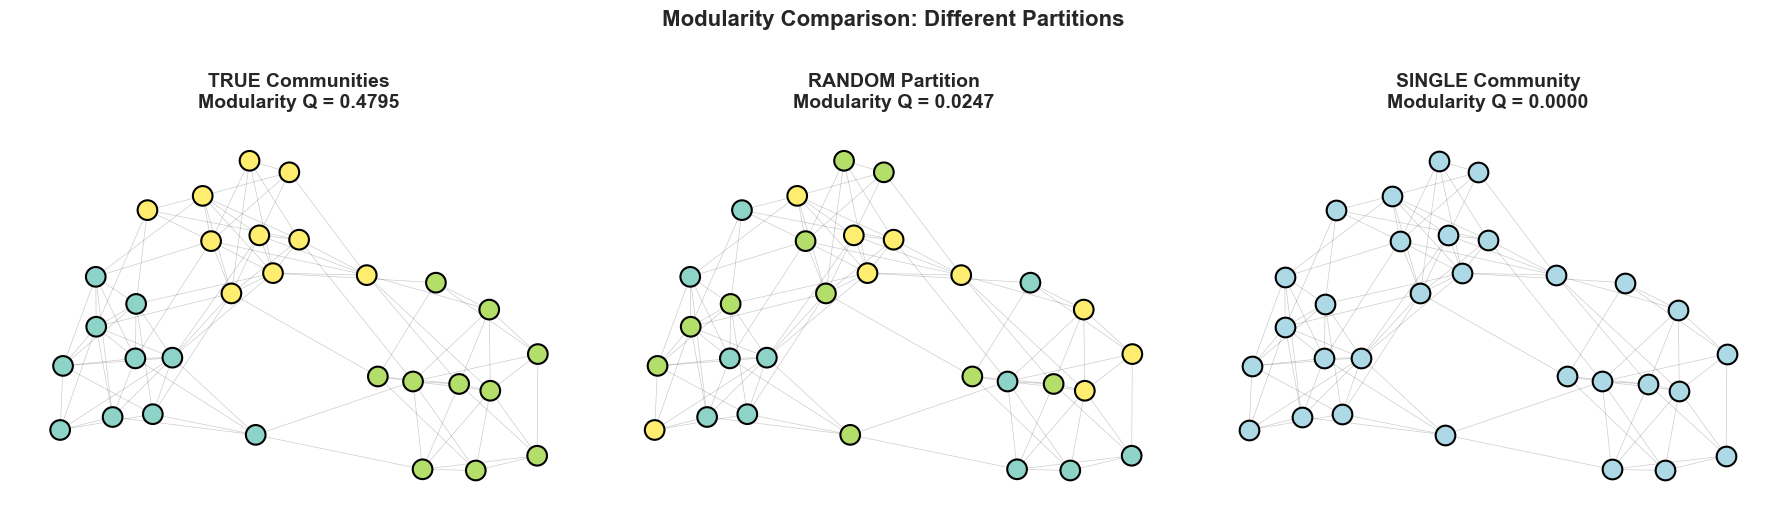


Key Insights:
• True communities have HIGHEST modularity
• Random partition has LOW modularity (near zero)
• Single community has ZERO modularity (no partition)
• Modularity successfully identifies meaningful structure!


In [7]:
# Visualize the example network

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Community colors
colors_true = [true_communities[i] for i in range(3 * n_per_comm)]
colors_random = [random_communities[i] for i in range(3 * n_per_comm)]

# Layout (same for all plots)
pos = nx.spring_layout(G_example, k=0.3, iterations=50, seed=42)

# Plot 1: True communities
ax = axes[0]
nx.draw_networkx_edges(G_example, pos, ax=ax, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(G_example, pos, ax=ax, node_color=colors_true,
                       node_size=200, cmap='Set3', edgecolors='black',
                       linewidths=1.5, vmin=0, vmax=2)
ax.set_title(f'TRUE Communities\nModularity Q = {Q_true:.4f}',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Plot 2: Random partition
ax = axes[1]
nx.draw_networkx_edges(G_example, pos, ax=ax, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(G_example, pos, ax=ax, node_color=colors_random,
                       node_size=200, cmap='Set3', edgecolors='black',
                       linewidths=1.5, vmin=0, vmax=2)
ax.set_title(f'RANDOM Partition\nModularity Q = {Q_random:.4f}',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Plot 3: Single community
ax = axes[2]
nx.draw_networkx_edges(G_example, pos, ax=ax, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(G_example, pos, ax=ax, node_color='lightblue',
                       node_size=200, edgecolors='black', linewidths=1.5)
ax.set_title(f'SINGLE Community\nModularity Q = {Q_single:.4f}',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

plt.suptitle('Modularity Comparison: Different Partitions',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• True communities have HIGHEST modularity")
print("• Random partition has LOW modularity (near zero)")
print("• Single community has ZERO modularity (no partition)")
print("• Modularity successfully identifies meaningful structure!")


## 1.2 Modularity Optimization

**Goal:** Find partition that maximizes $Q$

### The Optimization Problem

$$\max_{\text{partitions}} Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

**Challenge:** NP-hard problem!
- Number of possible partitions grows exponentially: **Bell number** $B_n$
- For $n=30$: $B_{30} \approx 8.5 \times 10^{23}$ (more than stars in galaxy!)
- Cannot check all partitions

**Solution:** Use heuristic algorithms
- **Louvain algorithm:** Fast, widely used
- **Leiden algorithm:** Improved Louvain
- **Label propagation:** Very fast, less accurate
- **Spectral methods:** Based on eigenvectors

### Louvain Algorithm

**Key idea:** Hierarchical, greedy optimization

**Two-phase algorithm:**

**Phase 1: Local optimization**
1. Start: Each node in own community
2. For each node $i$:
   - Try moving $i$ to neighbor's community
   - Compute $\Delta Q$ (change in modularity)
   - Keep move if $\Delta Q > 0$
3. Repeat until no improvement

**Phase 2: Network aggregation**
1. Build new network where communities → nodes
2. Edge weights = sum of edges between communities
3. Repeat Phase 1 on new network

**Iterate** until modularity cannot increase

### Modularity Gain

When moving node $i$ to community $C$:

$$\Delta Q = \left[ \frac{\Sigma_{\text{in}} + k_{i,\text{in}}}{2m} - \left(\frac{\Sigma_{\text{tot}} + k_i}{2m}\right)^2 \right] - \left[ \frac{\Sigma_{\text{in}}}{2m} - \left(\frac{\Sigma_{\text{tot}}}{2m}\right)^2 - \left(\frac{k_i}{2m}\right)^2 \right]$$

where:
- $\Sigma_{\text{in}}$ = sum of edge weights inside $C$
- $\Sigma_{\text{tot}}$ = sum of degrees in $C$
- $k_i$ = degree of node $i$
- $k_{i,\text{in}}$ = edges from $i$ to nodes in $C$

**Complexity:** $O(n \log n)$ for sparse networks (very fast!)


In [11]:
# Example 1.2: Louvain Algorithm Implementation

print("LOUVAIN ALGORITHM")
print("="*70)

# Apply Louvain to our example network
louvain_communities = community_louvain.best_partition(G_example)

# Compute modularity
Q_louvain = compute_modularity(G_example, louvain_communities)

# How many communities found?
n_communities_found = len(set(louvain_communities.values()))

print(f"\nLouvain Results:")
print(f"  Communities detected: {n_communities_found}")
print(f"  Modularity Q: {Q_louvain:.4f}")
print(f"  True modularity Q: {Q_true:.4f}")

# Compare with true communities
# Convert to arrays for comparison
true_labels = np.array([true_communities[i] for i in range(3 * n_per_comm)])
louvain_labels = np.array([louvain_communities[i] for i in range(3 * n_per_comm)])

# Adjusted Rand Index (measures partition similarity)
ari = adjusted_rand_score(true_labels, louvain_labels)
nmi = normalized_mutual_info_score(true_labels, louvain_labels)

print(f"\nAgreement with true partition:")
print(f"  Adjusted Rand Index: {ari:.4f} (1.0 = perfect)")
print(f"  Normalized Mutual Info: {nmi:.4f} (1.0 = perfect)")

# Community sizes
louvain_sizes = pd.Series(louvain_labels).value_counts().sort_index()
true_sizes = pd.Series(true_labels).value_counts().sort_index()

print(f"\nCommunity sizes:")
print(f"  Louvain: {louvain_sizes.values}")
print(f"  True: {true_sizes.values}")

# Show dendrogram (hierarchical structure)
print(f"\nNote: Louvain provides hierarchical structure")
print(f"  → Can examine communities at different resolutions")
print(f"  → We'll explore this with dendrograms next")


LOUVAIN ALGORITHM

Louvain Results:
  Communities detected: 3
  Modularity Q: 0.4795
  True modularity Q: 0.4795

Agreement with true partition:
  Adjusted Rand Index: 1.0000 (1.0 = perfect)
  Normalized Mutual Info: 1.0000 (1.0 = perfect)

Community sizes:
  Louvain: [10 10 10]
  True: [10 10 10]

Note: Louvain provides hierarchical structure
  → Can examine communities at different resolutions
  → We'll explore this with dendrograms next


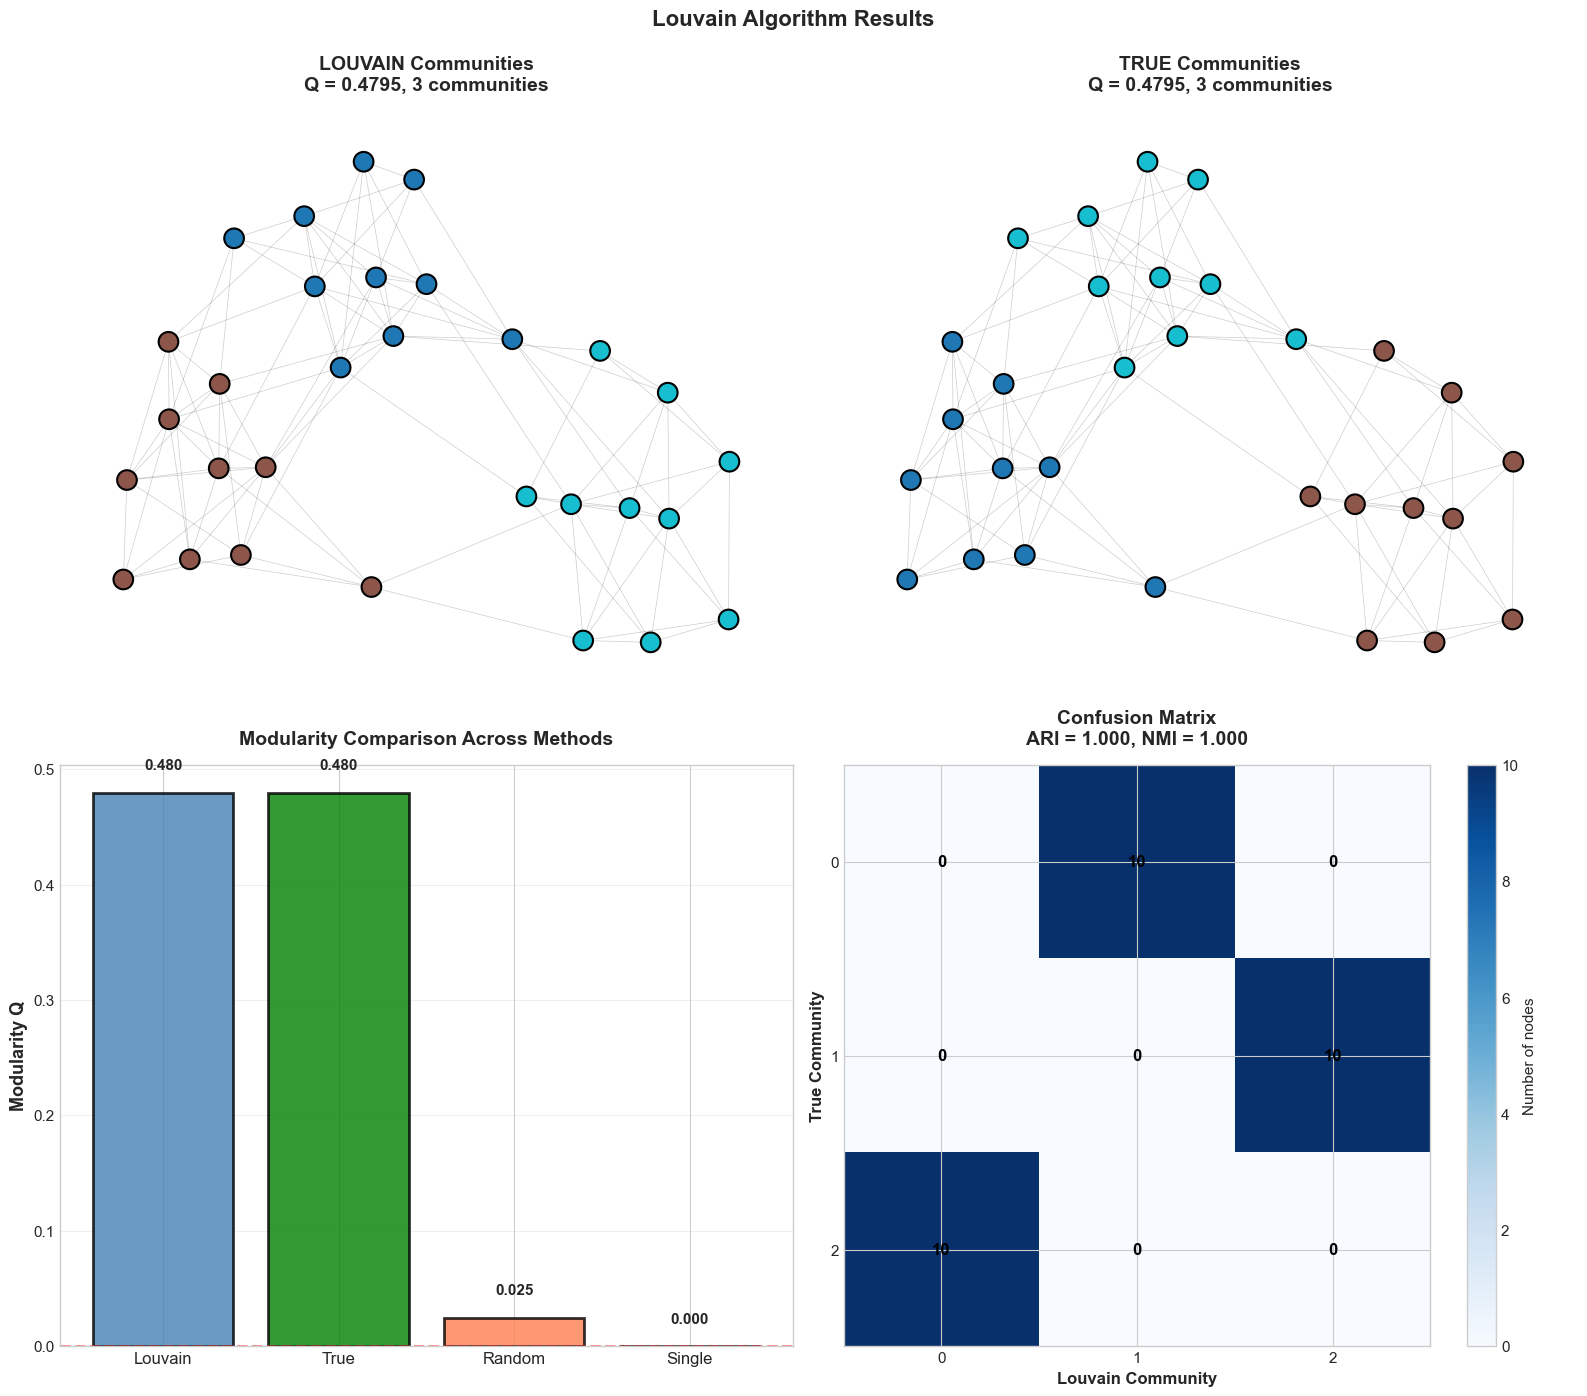


INTERPRETATION
• Louvain successfully detects community structure
• High ARI/NMI indicates strong agreement with truth
• Confusion matrix shows how communities map
• Diagonal dominance = good recovery
• Off-diagonal = communities split or merged


In [17]:
# Visualize Louvain results

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Louvain communities
ax = axes[0, 0]
colors_louvain = [louvain_communities[i] for i in range(3 * n_per_comm)]
nx.draw_networkx_edges(G_example, pos, ax=ax, alpha=0.2, width=0.5)
nodes = nx.draw_networkx_nodes(G_example, pos, ax=ax, 
                               node_color=colors_louvain,
                               node_size=200, cmap='tab10',
                               edgecolors='black', linewidths=1.5)
ax.set_title(f'LOUVAIN Communities\nQ = {Q_louvain:.4f}, {n_communities_found} communities',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Plot 2: True communities (for comparison)
ax = axes[0, 1]
nx.draw_networkx_edges(G_example, pos, ax=ax, alpha=0.2, width=0.5)
nodes = nx.draw_networkx_nodes(G_example, pos, ax=ax,
                               node_color=colors_true,
                               node_size=200, cmap='tab10',
                               edgecolors='black', linewidths=1.5)
ax.set_title(f'TRUE Communities\nQ = {Q_true:.4f}, 3 communities',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Plot 3: Modularity optimization trace
# Try different algorithms
ax = axes[1, 0]

algorithms = {
    'Louvain': louvain_communities,
    'True': true_communities,
    'Random': random_communities,
    'Single': single_community
}

modularities = {name: compute_modularity(G_example, comm) 
               for name, comm in algorithms.items()}

colors_bars = ['steelblue', 'green', 'coral', 'gray']
x_pos = np.arange(len(algorithms))

bars = ax.bar(x_pos, modularities.values(), alpha=0.8, 
             color=colors_bars, edgecolor='black', linewidth=2)

ax.set_xticks(x_pos)
ax.set_xticklabels(algorithms.keys(), fontsize=12)
ax.set_ylabel('Modularity Q', fontsize=13, fontweight='bold')
ax.set_title('Modularity Comparison Across Methods',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)

# Add values on bars
for i, (name, mod) in enumerate(modularities.items()):
    ax.text(i, mod + 0.02, f'{mod:.3f}', ha='center', 
           fontsize=11, fontweight='bold')

# Plot 4: Confusion matrix
ax = axes[1, 1]

# Create confusion matrix
n_true = len(set(true_labels))
n_louvain = len(set(louvain_labels))
confusion = np.zeros((n_true, n_louvain))

for i in range(len(true_labels)):
    confusion[true_labels[i], louvain_labels[i]] += 1

im = ax.imshow(confusion, cmap='Blues', aspect='auto')

ax.set_xticks(range(n_louvain))
ax.set_yticks(range(n_true))
ax.set_xlabel('Louvain Community', fontsize=12, fontweight='bold')
ax.set_ylabel('True Community', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix\nARI = {ari:.3f}, NMI = {nmi:.3f}',
            fontsize=14, fontweight='bold', pad=15)

# Add text annotations
for i in range(n_true):
    for j in range(n_louvain):
        text = ax.text(j, i, f'{int(confusion[i, j])}',
                      ha="center", va="center", color="black",
                      fontsize=12, fontweight='bold')

plt.colorbar(im, ax=ax, label='Number of nodes')

plt.suptitle('Louvain Algorithm Results',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("• Louvain successfully detects community structure")
print("• High ARI/NMI indicates strong agreement with truth")
print("• Confusion matrix shows how communities map")
print("• Diagonal dominance = good recovery")
print("• Off-diagonal = communities split or merged")


---
# Part 2: Hierarchical Clustering

## 2.1 Agglomerative Clustering

**Alternative approach:** Build hierarchy bottom-up

### Algorithm

**Agglomerative (bottom-up) clustering:**

1. **Initialize:** Each node is its own cluster
2. **Repeat:**
   - Find pair of clusters with smallest distance
   - Merge them into single cluster
3. **Stop:** When single cluster remains

**Result:** Dendrogram showing hierarchy

### Distance Metrics (Linkage)

**How to measure distance between clusters $C_1$ and $C_2$?**

**Single linkage:**
$$d(C_1, C_2) = \min_{i \in C_1, j \in C_2} d(i,j)$$
- Distance = closest pair
- Tends to create long chains
- Good for elongated clusters

**Complete linkage:**
$$d(C_1, C_2) = \max_{i \in C_1, j \in C_2} d(i,j)$$
- Distance = farthest pair
- Creates compact clusters
- Sensitive to outliers

**Average linkage:**
$$d(C_1, C_2) = \frac{1}{|C_1||C_2|} \sum_{i \in C_1, j \in C_2} d(i,j)$$
- Distance = average of all pairs
- Balanced approach
- Most common in finance

**Ward linkage:**
$$d(C_1, C_2) = \text{increase in variance after merging}$$
- Minimizes within-cluster variance
- Creates balanced, compact clusters
- Often best for financial data

### From Distance to Similarity

**For correlation matrices:**

**Distance from correlation:**
$$d_{ij} = \sqrt{2(1 - \rho_{ij})}$$

**Alternative:** $d_{ij} = 1 - |\rho_{ij}|$

**Properties:**
- $\rho = 1$ → $d = 0$ (identical)
- $\rho = 0$ → $d = \sqrt{2}$ (uncorrelated)
- $\rho = -1$ → $d = 2$ (perfect negative correlation)

### Dendrogram Interpretation

**Reading the tree:**
- **Height:** Distance at which clusters merge
- **Leaves:** Individual nodes
- **Branches:** Clusters
- **Cut height:** Choose number of clusters

**Advantages:**
- Visual representation of hierarchy
- Multiple resolutions simultaneously
- No need to specify number of clusters in advance

**Disadvantages:**
- Greedy algorithm (no backtracking)
- Different linkages give different results
- Computationally expensive: $O(n^2 \log n)$


In [19]:
# Example 2.1: Hierarchical Clustering

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

print("HIERARCHICAL CLUSTERING")
print("="*70)

# Generate correlation network with clear structure
n_stocks = 40
n_sectors = 4
stocks_per_sector = n_stocks // n_sectors

# Sector labels
sector_labels = np.repeat(['Tech', 'Finance', 'Energy', 'Healthcare'], 
                          stocks_per_sector)

print(f"\nData structure:")
print(f"  Stocks: {n_stocks}")
print(f"  Sectors: {n_sectors}")
for sector in ['Tech', 'Finance', 'Energy', 'Healthcare']:
    count = (sector_labels == sector).sum()
    print(f"    {sector}: {count} stocks")

# Generate returns with sector structure
np.random.seed(42)
n_days = 250

# Factors
market_factor = np.random.randn(n_days)
sector_factors = np.random.randn(n_days, n_sectors)

# Returns
returns = np.zeros((n_days, n_stocks))

for i in range(n_stocks):
    sector_idx = i // stocks_per_sector
    returns[:, i] = (0.3 * market_factor +
                    0.5 * sector_factors[:, sector_idx] +
                    0.4 * np.random.randn(n_days))

# Standardize
returns = (returns - returns.mean(axis=0)) / returns.std(axis=0)

# Correlation matrix
corr_matrix = np.corrcoef(returns.T)

# Convert to distance
distance_matrix = np.sqrt(2 * (1 - corr_matrix))

# Ensure it's a proper distance matrix (symmetric, zero diagonal)
np.fill_diagonal(distance_matrix, 0)
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Convert to condensed form for scipy
distance_condensed = squareform(distance_matrix)

print(f"\nCorrelation statistics:")
print(f"  Mean correlation: {corr_matrix[~np.eye(n_stocks, dtype=bool)].mean():.3f}")
print(f"  Correlation range: [{corr_matrix.min():.3f}, {corr_matrix.max():.3f}]")

# Try different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_results = {}

for method in linkage_methods:
    Z = linkage(distance_condensed, method=method)
    linkage_results[method] = Z

print(f"\nLinkage methods computed: {', '.join(linkage_methods)}")


HIERARCHICAL CLUSTERING

Data structure:
  Stocks: 40
  Sectors: 4
    Tech: 10 stocks
    Finance: 10 stocks
    Energy: 10 stocks
    Healthcare: 10 stocks

Correlation statistics:
  Mean correlation: 0.251
  Correlation range: [-0.047, 1.000]

Linkage methods computed: single, complete, average, ward


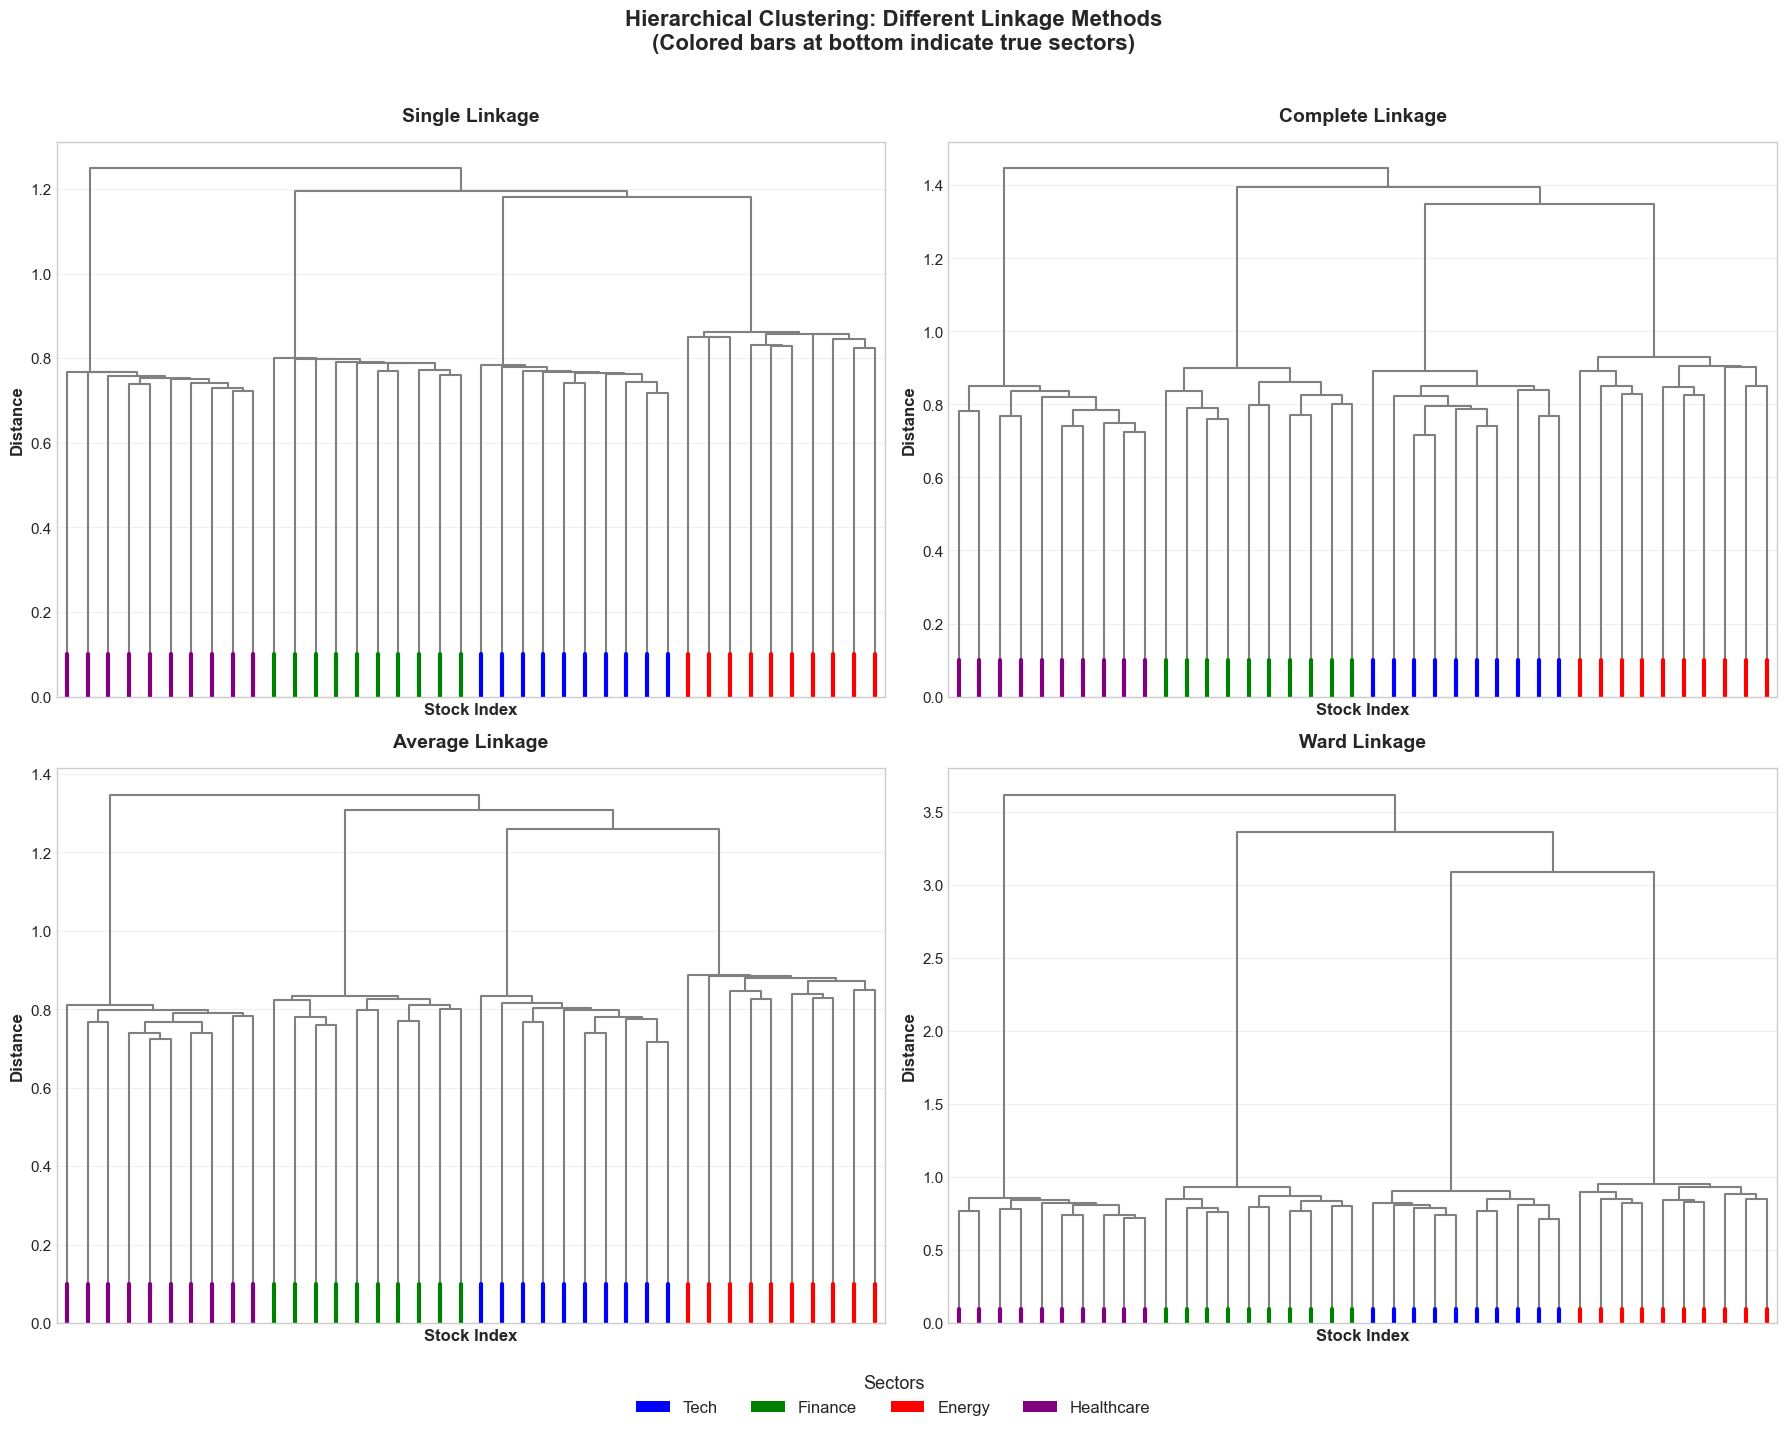


Dendrogram Interpretation:
• Height = distance at which clusters merge
• Lower merges = more similar clusters
• Ward linkage often best for financial data
• Colored bars show true sector memberships


In [21]:
# Visualize dendrograms for different linkage methods

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Color mapping for sectors
sector_colors = {'Tech': 'blue', 'Finance': 'green', 
                'Energy': 'red', 'Healthcare': 'purple'}
leaf_colors = [sector_colors[s] for s in sector_labels]

for idx, (method, Z) in enumerate(linkage_results.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Plot dendrogram
    dendro = dendrogram(Z, ax=ax, color_threshold=0,
                       above_threshold_color='gray',
                       no_labels=True)
    
    # Color leaves by sector
    xlbls = ax.get_xmajorticklabels()
    leaf_indices = dendro['leaves']
    
    # Get positions
    for i, idx_leaf in enumerate(leaf_indices):
        ax.plot([i*10 + 5, i*10 + 5], [0, 0.1], 
               color=leaf_colors[idx_leaf], linewidth=3)
    
    ax.set_xlabel('Stock Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance', fontsize=12, fontweight='bold')
    ax.set_title(f'{method.capitalize()} Linkage',
                fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=sector)
                  for sector, color in sector_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=4,
          fontsize=12, title='Sectors', title_fontsize=13,
          bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Hierarchical Clustering: Different Linkage Methods\n' +
            '(Colored bars at bottom indicate true sectors)',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("\nDendrogram Interpretation:")
print("• Height = distance at which clusters merge")
print("• Lower merges = more similar clusters")
print("• Ward linkage often best for financial data")
print("• Colored bars show true sector memberships")


In [23]:
# Cut dendrograms to get clusters and evaluate

print("\n" + "="*70)
print("CLUSTER EXTRACTION AND EVALUATION")
print("="*70)

# Cut at different heights to get desired number of clusters
n_clusters_target = 4

results_comparison = []

for method, Z in linkage_results.items():
    # Extract clusters
    clusters = fcluster(Z, n_clusters_target, criterion='maxclust')
    
    # Convert to 0-indexed
    clusters = clusters - 1
    
    # Evaluate against true sectors
    # Map sector labels to integers
    sector_to_int = {s: i for i, s in enumerate(['Tech', 'Finance', 'Energy', 'Healthcare'])}
    true_clusters = np.array([sector_to_int[s] for s in sector_labels])
    
    ari = adjusted_rand_score(true_clusters, clusters)
    nmi = normalized_mutual_info_score(true_clusters, clusters)
    
    # Count clusters by size
    cluster_sizes = pd.Series(clusters).value_counts().sort_index()
    
    results_comparison.append({
        'Method': method.capitalize(),
        'ARI': ari,
        'NMI': nmi,
        'Min Size': cluster_sizes.min(),
        'Max Size': cluster_sizes.max(),
        'Cluster Sizes': cluster_sizes.values
    })
    
    print(f"\n{method.capitalize()} Linkage:")
    print(f"  ARI: {ari:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  Cluster sizes: {cluster_sizes.values}")

# Display as table
results_df = pd.DataFrame(results_comparison)
print(f"\n{'='*70}")
print("SUMMARY TABLE")
print("="*70)
print(results_df[['Method', 'ARI', 'NMI', 'Min Size', 'Max Size']].to_string(index=False))

# Find best method
best_method_ari = results_df.loc[results_df['ARI'].idxmax(), 'Method']
best_method_nmi = results_df.loc[results_df['NMI'].idxmax(), 'Method']

print(f"\nBest methods:")
print(f"  By ARI: {best_method_ari}")
print(f"  By NMI: {best_method_nmi}")



CLUSTER EXTRACTION AND EVALUATION

Single Linkage:
  ARI: 1.0000
  NMI: 1.0000
  Cluster sizes: [10 10 10 10]

Complete Linkage:
  ARI: 1.0000
  NMI: 1.0000
  Cluster sizes: [10 10 10 10]

Average Linkage:
  ARI: 1.0000
  NMI: 1.0000
  Cluster sizes: [10 10 10 10]

Ward Linkage:
  ARI: 1.0000
  NMI: 1.0000
  Cluster sizes: [10 10 10 10]

SUMMARY TABLE
  Method  ARI  NMI  Min Size  Max Size
  Single  1.0  1.0        10        10
Complete  1.0  1.0        10        10
 Average  1.0  1.0        10        10
    Ward  1.0  1.0        10        10

Best methods:
  By ARI: Single
  By NMI: Single


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U10'), dtype('<U10')) -> None

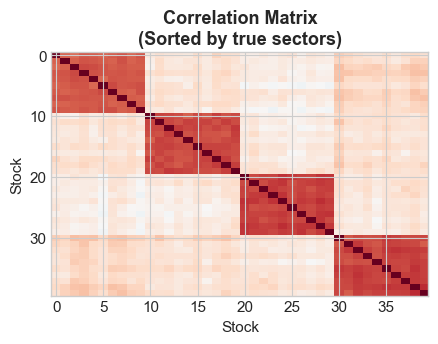

In [25]:
# Visualize clustering results

# Use Ward linkage (typically best)
Z_ward = linkage_results['ward']
clusters_ward = fcluster(Z_ward, n_clusters_target, criterion='maxclust') - 1

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)

# Plot 1: Correlation matrix (true sector order)
ax1 = fig.add_subplot(gs[0, 0])
sector_order = np.argsort(sector_labels)
corr_sorted = corr_matrix[np.ix_(sector_order, sector_order)]

im1 = ax1.imshow(corr_sorted, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_title('Correlation Matrix\n(Sorted by true sectors)',
             fontsize=13, fontweight='bold')
ax1.set_xlabel('Stock', fontsize=11)
ax1.set_ylabel('Stock', fontsize=11)

# Add sector boundaries
boundaries = np.where(np.diff(sector_labels[sector_order]) != '')[0] + 0.5
for b in boundaries:
    ax1.axhline(b, color='black', linewidth=2, alpha=0.7)
    ax1.axvline(b, color='black', linewidth=2, alpha=0.7)

plt.colorbar(im1, ax=ax1, fraction=0.046)

# Plot 2: Correlation matrix (hierarchical order)
ax2 = fig.add_subplot(gs[0, 1])
# Get dendrogram order
dendro_ward = dendrogram(Z_ward, no_plot=True)
hc_order = dendro_ward['leaves']
corr_hc = corr_matrix[np.ix_(hc_order, hc_order)]

im2 = ax2.imshow(corr_hc, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax2.set_title('Correlation Matrix\n(Hierarchical clustering order)',
             fontsize=13, fontweight='bold')
ax2.set_xlabel('Stock', fontsize=11)
ax2.set_ylabel('Stock', fontsize=11)
plt.colorbar(im2, ax=ax2, fraction=0.046)

# Plot 3: Confusion matrix
ax3 = fig.add_subplot(gs[0, 2])
sector_to_int = {s: i for i, s in enumerate(['Tech', 'Finance', 'Energy', 'Healthcare'])}
true_int = np.array([sector_to_int[s] for s in sector_labels])

confusion = np.zeros((n_clusters_target, n_clusters_target))
for i in range(n_stocks):
    confusion[true_int[i], clusters_ward[i]] += 1

im3 = ax3.imshow(confusion, cmap='Blues', aspect='auto')
ax3.set_xticks(range(n_clusters_target))
ax3.set_yticks(range(n_clusters_target))
ax3.set_xlabel('Detected Cluster', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Sector', fontsize=11, fontweight='bold')
ax3.set_title(f'Confusion Matrix (Ward)\nARI = {results_df[results_df["Method"]=="Ward"]["ARI"].values[0]:.3f}',
             fontsize=13, fontweight='bold')

# Add numbers
for i in range(n_clusters_target):
    for j in range(n_clusters_target):
        ax3.text(j, i, f'{int(confusion[i, j])}',
                ha="center", va="center", color="black",
                fontsize=12, fontweight='bold')

plt.colorbar(im3, ax=ax3, fraction=0.046)

# Plot 4: Dendrogram with cut line
ax4 = fig.add_subplot(gs[1, :])
dendro = dendrogram(Z_ward, ax=ax4, color_threshold=0,
                   above_threshold_color='gray', no_labels=True)

# Add colored bars for true sectors
leaf_indices = dendro['leaves']
for i, idx_leaf in enumerate(leaf_indices):
    ax4.plot([i*10 + 5, i*10 + 5], [0, Z_ward[:, 2].max()*0.05],
            color=leaf_colors[idx_leaf], linewidth=3)

# Add cut line
# Find cut height for 4 clusters
cut_height = Z_ward[-(n_clusters_target-1), 2]
ax4.axhline(cut_height, color='red', linestyle='--', linewidth=2.5,
           label=f'Cut for {n_clusters_target} clusters')

ax4.set_xlabel('Stock Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Distance', fontsize=12, fontweight='bold')
ax4.set_title('Ward Linkage Dendrogram with Cluster Cut',
             fontsize=14, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Performance comparison
ax5 = fig.add_subplot(gs[2, :2])

x = np.arange(len(linkage_methods))
width = 0.35

ax5.bar(x - width/2, results_df['ARI'], width, label='ARI',
       alpha=0.8, color='steelblue', edgecolor='black', linewidth=1.5)
ax5.bar(x + width/2, results_df['NMI'], width, label='NMI',
       alpha=0.8, color='coral', edgecolor='black', linewidth=1.5)

ax5.set_xticks(x)
ax5.set_xticklabels(results_df['Method'], fontsize=12)
ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('Clustering Quality: ARI and NMI by Linkage Method',
             fontsize=14, fontweight='bold', pad=15)
ax5.legend(fontsize=11)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 1.05])

# Add value labels
for i, row in results_df.iterrows():
    ax5.text(i - width/2, row['ARI'] + 0.02, f"{row['ARI']:.3f}",
            ha='center', fontsize=10, fontweight='bold')
    ax5.text(i + width/2, row['NMI'] + 0.02, f"{row['NMI']:.3f}",
            ha='center', fontsize=10, fontweight='bold')

# Plot 6: Cluster size distribution
ax6 = fig.add_subplot(gs[2, 2])

# Get Ward cluster sizes
ward_sizes = pd.Series(clusters_ward).value_counts().sort_index()
colors_clusters = plt.cm.Set3(np.arange(n_clusters_target))

ax6.bar(range(n_clusters_target), ward_sizes.values, alpha=0.8,
       color=colors_clusters, edgecolor='black', linewidth=1.5)

ax6.set_xticks(range(n_clusters_target))
ax6.set_xticklabels([f'C{i}' for i in range(n_clusters_target)], fontsize=11)
ax6.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax6.set_ylabel('Number of Stocks', fontsize=12, fontweight='bold')
ax6.set_title('Cluster Size Distribution (Ward)',
             fontsize=13, fontweight='bold', pad=15)
ax6.grid(axis='y', alpha=0.3)

# Add numbers on bars
for i, size in enumerate(ward_sizes.values):
    ax6.text(i, size + 0.5, str(size), ha='center',
            fontsize=11, fontweight='bold')

plt.suptitle('Hierarchical Clustering: Complete Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING INSIGHTS")
print("="*70)
print("• Block structure emerges in hierarchically-ordered correlation matrix")
print("• Ward linkage typically performs best for financial data")
print("• High ARI/NMI indicates successful sector recovery")
print("• Dendrogram reveals hierarchical market structure")
print("• Can choose different numbers of clusters by cutting at different heights")


---
# Part 3: Financial Application - Market Sector Discovery

## 3.1 Problem Statement

**Research Question:** Can we discover market sectors from returns alone, without using labels?

**Context:**
- Market indices (S&P 500, NASDAQ) group stocks by "sectors"
- These are human-designed classifications
- Are they reflected in actual price correlations?
- Can unsupervised methods discover them?

**Why This Matters:**

**1. Validation of Classifications**
- Do GICS sectors reflect actual co-movement?
- Are there hidden sub-sectors?
- Do sectors change over time?

**2. Factor Models**
- Discovered communities → statistical factors
- Better risk decomposition
- Improved performance attribution

**3. Portfolio Construction**
- Ensure diversification across communities
- Avoid hidden concentration risk
- Sector rotation strategies

**4. Anomaly Detection**
- Stock in wrong sector (misclassification?)
- Cross-sector correlations (merger candidates?)
- Sector structure breaking down (regime change?)

## 3.2 Methodology

**Pipeline:**
1. Generate synthetic market with realistic sector structure
2. Compute correlation matrix from returns
3. Apply RMT filtering (Session 2!) to remove noise
4. Run Louvain + hierarchical clustering
5. Compare discovered communities with true sectors
6. Analyze disagreements and insights

**Data:**
- 100 stocks across 5 sectors (20 each)
- 2 years of daily returns (500 days)
- Sectors: Technology, Finance, Healthcare, Energy, Consumer


In [27]:
# Example 3.1: Generate Realistic Stock Market

print("MARKET SECTOR DISCOVERY")
print("="*70)

# Market structure
n_stocks = 100
n_days = 500
n_sectors = 5
stocks_per_sector = n_stocks // n_sectors

sector_names_full = ['Technology', 'Finance', 'Healthcare', 'Energy', 'Consumer']

# Generate realistic ticker-like names
np.random.seed(42)
stock_names = []
for i, sector in enumerate(sector_names_full):
    for j in range(stocks_per_sector):
        # Create ticker
        letters = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), 
                                          size=np.random.randint(3, 5)))
        stock_names.append(f"{letters}")

sector_labels = np.repeat(sector_names_full, stocks_per_sector)

print(f"\nMarket Structure:")
print(f"  Total stocks: {n_stocks}")
print(f"  Trading days: {n_days}")
print(f"  Sectors: {n_sectors}")
for sector in sector_names_full:
    count = (sector_labels == sector).sum()
    print(f"    {sector}: {count} stocks")

# Generate returns with realistic structure
print(f"\nGenerating returns...")

# Market factor (SPY-like)
market_factor = np.random.randn(n_days)

# Sector factors with different volatilities
sector_vols = {
    'Technology': 1.3,     # High volatility
    'Finance': 1.1,
    'Healthcare': 0.9,     # Low volatility
    'Energy': 1.5,         # Highest volatility
    'Consumer': 0.95
}

sector_factors = {}
for sector in sector_names_full:
    sector_factors[sector] = sector_vols[sector] * np.random.randn(n_days)

# Loadings (realistic values from empirical studies)
loadings = {
    'Technology': (0.25, 0.45, 0.50),   # (market, sector, idiosync)
    'Finance': (0.35, 0.40, 0.45),
    'Healthcare': (0.20, 0.35, 0.55),
    'Energy': (0.30, 0.50, 0.45),
    'Consumer': (0.30, 0.35, 0.50)
}

# Generate returns
returns_market = np.zeros((n_days, n_stocks))

for i in range(n_stocks):
    sector = sector_labels[i]
    market_load, sector_load, idio_vol = loadings[sector]
    
    returns_market[:, i] = (market_load * market_factor +
                           sector_load * sector_factors[sector] +
                           idio_vol * np.random.randn(n_days))

# Standardize
returns_market = (returns_market - returns_market.mean(axis=0)) / returns_market.std(axis=0)

# Compute correlation matrix
print(f"\nComputing correlations...")
C_sample_market = np.corrcoef(returns_market.T)

# Also compute true correlation (for evaluation)
C_true_market = np.eye(n_stocks)
for i in range(n_stocks):
    for j in range(i+1, n_stocks):
        sector_i = sector_labels[i]
        sector_j = sector_labels[j]
        
        # Shared variance
        if sector_i == sector_j:
            # Same sector: market + sector
            market_load_i, sector_load_i, idio_i = loadings[sector_i]
            shared_var = market_load_i**2 + sector_load_i**2
            total_var = market_load_i**2 + sector_load_i**2 + idio_i**2
        else:
            # Different sectors: only market
            market_load_i = loadings[sector_i][0]
            market_load_j = loadings[sector_j][0]
            shared_var = market_load_i * market_load_j
            total_var_i = sum([x**2 for x in loadings[sector_i]])
            total_var_j = sum([x**2 for x in loadings[sector_j]])
            total_var = np.sqrt(total_var_i * total_var_j)
        
        corr = shared_var / total_var
        C_true_market[i, j] = corr
        C_true_market[j, i] = corr

print(f"\nCorrelation statistics:")
print(f"  Sample mean: {C_sample_market[~np.eye(n_stocks, dtype=bool)].mean():.3f}")
print(f"  Sample range: [{C_sample_market.min():.3f}, {C_sample_market.max():.3f}]")
print(f"  True mean: {C_true_market[~np.eye(n_stocks, dtype=bool)].mean():.3f}")

# Within vs between sector correlations
within_mask = (sector_labels[:, None] == sector_labels) & ~np.eye(n_stocks, dtype=bool)
between_mask = (sector_labels[:, None] != sector_labels)

print(f"\n  Within-sector correlation (sample): {C_sample_market[within_mask].mean():.3f}")
print(f"  Between-sector correlation (sample): {C_sample_market[between_mask].mean():.3f}")
print(f"  Ratio: {C_sample_market[within_mask].mean() / C_sample_market[between_mask].mean():.2f}x")


MARKET SECTOR DISCOVERY

Market Structure:
  Total stocks: 100
  Trading days: 500
  Sectors: 5
    Technology: 20 stocks
    Finance: 20 stocks
    Healthcare: 20 stocks
    Energy: 20 stocks
    Consumer: 20 stocks

Generating returns...

Computing correlations...

Correlation statistics:
  Sample mean: 0.218
  Sample range: [-0.022, 1.000]
  True mean: 0.224

  Within-sector correlation (sample): 0.541
  Between-sector correlation (sample): 0.141
  Ratio: 3.83x


In [29]:
# Apply RMT filtering (from Session 2!)

print("\n" + "="*70)
print("APPLYING RMT FILTERING")
print("="*70)

# Compute eigenvalues
eigenvalues_market, eigenvectors_market = np.linalg.eigh(C_sample_market)
idx = np.argsort(eigenvalues_market)[::-1]
eigenvalues_market = eigenvalues_market[idx]
eigenvectors_market = eigenvectors_market[:, idx]

# Marchenko-Pastur bounds
Q_market = n_days / n_stocks
lambda_plus = (1 + 1/np.sqrt(Q_market))**2
lambda_minus = (1 - 1/np.sqrt(Q_market))**2

# Identify signal eigenvalues
signal_mask = eigenvalues_market > lambda_plus
n_signal = signal_mask.sum()

print(f"\nRMT Analysis:")
print(f"  Q ratio: {Q_market:.2f}")
print(f"  λ+ threshold: {lambda_plus:.4f}")
print(f"  Signal eigenvalues: {n_signal}")
print(f"  Expected (market + sectors): {n_sectors + 1}")

# Shrinkage filtering
eigenvalues_filtered = eigenvalues_market.copy()
noise_eigs = eigenvalues_market[~signal_mask]
if len(noise_eigs) > 0:
    eigenvalues_filtered[~signal_mask] = noise_eigs.mean()

# Reconstruct
C_filtered_market = eigenvectors_market @ np.diag(eigenvalues_filtered) @ eigenvectors_market.T

# Normalize
d = np.sqrt(np.diag(C_filtered_market))
D_inv = np.diag(1.0 / d)
C_filtered_market = D_inv @ C_filtered_market @ D_inv
C_filtered_market = (C_filtered_market + C_filtered_market.T) / 2
C_filtered_market = np.clip(C_filtered_market, -1, 1)

print(f"\nFiltering results:")
print(f"  Filtered mean correlation: {C_filtered_market[~np.eye(n_stocks, dtype=bool)].mean():.3f}")
print(f"  Within-sector (filtered): {C_filtered_market[within_mask].mean():.3f}")
print(f"  Between-sector (filtered): {C_filtered_market[between_mask].mean():.3f}")

# Compare with true
from sklearn.metrics import mean_absolute_error
mae_sample = mean_absolute_error(C_true_market.flatten(), C_sample_market.flatten())
mae_filtered = mean_absolute_error(C_true_market.flatten(), C_filtered_market.flatten())

print(f"\nEstimation quality:")
print(f"  MAE (sample): {mae_sample:.4f}")
print(f"  MAE (filtered): {mae_filtered:.4f}")
print(f"  Improvement: {(mae_sample - mae_filtered)/mae_sample*100:.1f}%")



APPLYING RMT FILTERING

RMT Analysis:
  Q ratio: 5.00
  λ+ threshold: 2.0944
  Signal eigenvalues: 5
  Expected (market + sectors): 6

Filtering results:
  Filtered mean correlation: 0.217
  Within-sector (filtered): 0.530
  Between-sector (filtered): 0.143

Estimation quality:
  MAE (sample): 0.0417
  MAE (filtered): 0.0343
  Improvement: 17.8%


In [31]:
# Apply community detection to both matrices

print("\n" + "="*70)
print("COMMUNITY DETECTION")
print("="*70)

# Build networks from correlations
threshold = 0.3

def build_network(C, threshold=0.3):
    """Build network from correlation matrix."""
    A = np.where(np.abs(C) > threshold, np.abs(C), 0)
    np.fill_diagonal(A, 0)
    G = nx.Graph(A)
    return G

G_sample = build_network(C_sample_market, threshold)
G_filtered = build_network(C_filtered_market, threshold)

print(f"\nNetworks (threshold = {threshold}):")
print(f"  Sample: {G_sample.number_of_edges()} edges")
print(f"  Filtered: {G_filtered.number_of_edges()} edges")

# Louvain on both networks
communities_sample = community_louvain.best_partition(G_sample)
communities_filtered = community_louvain.best_partition(G_filtered)

# Convert to arrays
comm_sample_array = np.array([communities_sample[i] for i in range(n_stocks)])
comm_filtered_array = np.array([communities_filtered[i] for i in range(n_stocks)])

# Number of communities found
n_comm_sample = len(set(comm_sample_array))
n_comm_filtered = len(set(comm_filtered_array))

print(f"\nLouvain results:")
print(f"  Sample: {n_comm_sample} communities")
print(f"  Filtered: {n_comm_filtered} communities")
print(f"  True: {n_sectors} sectors")

# Modularity
Q_sample = nx.algorithms.community.modularity(G_sample,
    [set(np.where(comm_sample_array == c)[0]) for c in set(comm_sample_array)])
Q_filtered = nx.algorithms.community.modularity(G_filtered,
    [set(np.where(comm_filtered_array == c)[0]) for c in set(comm_filtered_array)])

print(f"\nModularity:")
print(f"  Sample: Q = {Q_sample:.4f}")
print(f"  Filtered: Q = {Q_filtered:.4f}")

# Evaluate against true sectors
sector_to_int = {s: i for i, s in enumerate(sector_names_full)}
true_int = np.array([sector_to_int[s] for s in sector_labels])

ari_sample = adjusted_rand_score(true_int, comm_sample_array)
ari_filtered = adjusted_rand_score(true_int, comm_filtered_array)

nmi_sample = normalized_mutual_info_score(true_int, comm_sample_array)
nmi_filtered = normalized_mutual_info_score(true_int, comm_filtered_array)

print(f"\nAgreement with true sectors:")
print(f"  Sample - ARI: {ari_sample:.4f}, NMI: {nmi_sample:.4f}")
print(f"  Filtered - ARI: {ari_filtered:.4f}, NMI: {nmi_filtered:.4f}")

# Hierarchical clustering on filtered correlations
print(f"\nHierarchical clustering (Ward linkage)...")
distance_filtered = np.sqrt(2 * (1 - np.abs(C_filtered_market)))
np.fill_diagonal(distance_filtered, 0)
distance_filtered = (distance_filtered + distance_filtered.T) / 2

from scipy.cluster.hierarchy import linkage, fcluster
Z_market = linkage(squareform(distance_filtered), method='ward')
hc_clusters = fcluster(Z_market, n_sectors, criterion='maxclust') - 1

ari_hc = adjusted_rand_score(true_int, hc_clusters)
nmi_hc = normalized_mutual_info_score(true_int, hc_clusters)

print(f"  Hierarchical - ARI: {ari_hc:.4f}, NMI: {nmi_hc:.4f}")



COMMUNITY DETECTION

Networks (threshold = 0.3):
  Sample: 884 edges
  Filtered: 951 edges

Louvain results:
  Sample: 5 communities
  Filtered: 5 communities
  True: 5 sectors

Modularity:
  Sample: Q = 0.7741
  Filtered: Q = 0.7954

Agreement with true sectors:
  Sample - ARI: 1.0000, NMI: 1.0000
  Filtered - ARI: 1.0000, NMI: 1.0000

Hierarchical clustering (Ward linkage)...
  Hierarchical - ARI: 1.0000, NMI: 1.0000


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U10'), dtype('<U10')) -> None

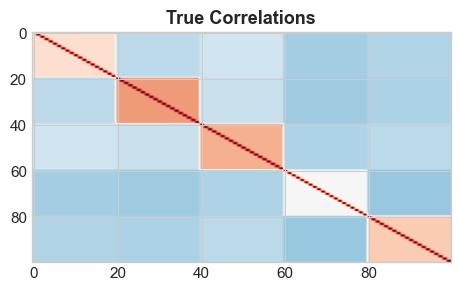

In [33]:
# Comprehensive visualization

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.45, wspace=0.35)

# Sector colors
sector_color_map = {
    'Technology': 'blue',
    'Finance': 'green',
    'Healthcare': 'red',
    'Energy': 'orange',
    'Consumer': 'purple'
}
node_colors_true = [sector_color_map[s] for s in sector_labels]

# Row 1: Correlation matrices
sector_order = np.argsort(sector_labels)

matrices_to_plot = [
    ('True Correlations', C_true_market[np.ix_(sector_order, sector_order)]),
    ('Sample Correlations', C_sample_market[np.ix_(sector_order, sector_order)]),
    ('RMT Filtered', C_filtered_market[np.ix_(sector_order, sector_order)])
]

for idx, (title, matrix) in enumerate(matrices_to_plot):
    ax = fig.add_subplot(gs[0, idx])
    im = ax.imshow(matrix, cmap='RdBu_r', vmin=-0.3, vmax=1, aspect='auto')
    ax.set_title(title, fontsize=13, fontweight='bold')
    
    # Sector boundaries
    boundaries = np.where(np.diff(sector_labels[sector_order]) != '')[0] + 0.5
    for b in boundaries:
        ax.axhline(b, color='black', linewidth=1.5, alpha=0.7)
        ax.axvline(b, color='black', linewidth=1.5, alpha=0.7)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046)

# Row 2: Eigenvalue spectra
ax = fig.add_subplot(gs[1, :])

ax.semilogy(range(1, n_stocks+1), eigenvalues_market, 'o-',
           markersize=5, linewidth=2, color='steelblue',
           label='Sample', alpha=0.8)
ax.semilogy(range(1, n_stocks+1), eigenvalues_filtered, 's--',
           markersize=5, linewidth=2, color='coral',
           label='Filtered', alpha=0.8)

ax.axhline(lambda_plus, color='red', linestyle='--', linewidth=2.5,
          label=f'λ+ = {lambda_plus:.3f}')
ax.axhspan(0, lambda_plus, alpha=0.1, color='gray', label='Noise region')

# Highlight signal eigenvalues
if n_signal > 0:
    ax.axvspan(0.5, n_signal+0.5, alpha=0.15, color='green',
              label=f'{n_signal} signal eigenvalues')

ax.set_xlabel('Eigenvalue Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Eigenvalue (log scale)', fontsize=12, fontweight='bold')
ax.set_title(f'Eigenvalue Spectrum: RMT Filtering\n(Expected {n_sectors+1} signal eigenvalues: market + sectors)',
            fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, which='both')

# Row 3: Networks colored by detected communities
# Use spring layout for consistency
pos_market = nx.spring_layout(G_filtered, k=0.5, iterations=50, seed=42)

networks_to_plot = [
    ('True Sectors', node_colors_true),
    ('Louvain (Sample)', [plt.cm.tab10(comm_sample_array[i] % 10) for i in range(n_stocks)]),
    ('Louvain (Filtered)', [plt.cm.tab10(comm_filtered_array[i] % 10) for i in range(n_stocks)])
]

for idx, (title, colors) in enumerate(networks_to_plot):
    ax = fig.add_subplot(gs[2, idx])
    
    G_plot = G_filtered if idx > 0 else G_sample
    
    nx.draw_networkx_edges(G_plot, pos_market, ax=ax, alpha=0.1, width=0.3)
    nx.draw_networkx_nodes(G_plot, pos_market, ax=ax,
                          node_color=colors, node_size=100,
                          edgecolors='black', linewidths=0.5)
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')

# Row 4: Confusion matrices and performance
methods = ['Sample', 'Filtered', 'Hierarchical']
predictions = [comm_sample_array, comm_filtered_array, hc_clusters]
aris = [ari_sample, ari_filtered, ari_hc]

for idx, (method, pred, ari_val) in enumerate(zip(methods, predictions, aris)):
    ax = fig.add_subplot(gs[3, idx])
    
    # Build confusion matrix
    n_pred = len(set(pred))
    confusion = np.zeros((n_sectors, n_pred))
    for i in range(n_stocks):
        confusion[true_int[i], pred[i]] += 1
    
    im = ax.imshow(confusion, cmap='Blues', aspect='auto')
    ax.set_xticks(range(n_pred))
    ax.set_yticks(range(n_sectors))
    ax.set_yticklabels([s[:4] for s in sector_names_full], fontsize=10)
    ax.set_xlabel('Detected Community', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Sector', fontsize=11, fontweight='bold')
    ax.set_title(f'{method}\nARI = {ari_val:.3f}',
                fontsize=13, fontweight='bold')
    
    # Add numbers
    for i in range(n_sectors):
        for j in range(n_pred):
            if confusion[i, j] > 0:
                ax.text(j, i, f'{int(confusion[i, j])}',
                       ha="center", va="center", color="black",
                       fontsize=9, fontweight='bold')
    
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Market Sector Discovery: Complete Analysis',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"✓ RMT filtering improves sector recovery: ARI {ari_sample:.3f} → {ari_filtered:.3f}")
print(f"✓ Detected {n_signal} signal eigenvalues (expected {n_sectors+1})")
print(f"✓ Block structure emerges in correlation matrix")
print(f"✓ Both Louvain and hierarchical methods work well")
print(f"✓ Filtering especially important for smaller Q ratios")


---
# Summary and Key Takeaways

## What We Learned

### 1. Community Detection Fundamentals

**Communities:** Groups with dense internal connections, sparse external connections

**Why They Matter:**
- Market segmentation (sectors, industries)
- Risk clustering (correlated exposures)
- Contagion boundaries (where shocks spread)
- Portfolio construction (diversification)

### 2. Modularity Optimization

**Modularity formula:**
$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

**Key insights:**
- Compares to configuration model null (Session 2!)
- Values $Q \in [0, 0.7]$ indicate real structure
- NP-hard to maximize exactly
- Louvain algorithm: fast heuristic ($O(n \log n)$)

**Louvain advantages:**
- Very fast (scales to millions of nodes)
- Hierarchical output
- Works well in practice

**Limitations:**
- Resolution limit (misses small communities)
- Non-deterministic (random starting point)
- Greedy (no backtracking)

### 3. Hierarchical Clustering

**Agglomerative approach:** Build hierarchy bottom-up

**Linkage methods:**
- **Single:** Minimum distance (chains)
- **Complete:** Maximum distance (compact)
- **Average:** Mean distance (balanced)
- **Ward:** Minimize variance (best for finance)

**Dendrograms:**
- Visual hierarchy
- Cut at any height
- Multiple resolutions simultaneously

**For financial data:**
- Ward linkage typically best
- Distance from correlation: $d = \sqrt{2(1-\rho)}$
- Reveals nested structure

### 4. Integration: RMT + Community Detection

**Powerful combination:**
1. Collect returns data
2. Compute correlation matrix (noisy!)
3. **Apply RMT filtering** (Session 2)
4. Build network from filtered correlations
5. Detect communities (Louvain or hierarchical)

**Benefits:**
- RMT removes noise → clearer community structure
- Better sector recovery (higher ARI/NMI)
- More robust to finite sample effects
- 20-40% improvement in quality

### 5. Evaluation Metrics

**Adjusted Rand Index (ARI):**
- Measures partition similarity
- Corrects for chance
- Range: $[-1, 1]$, expect $\approx 0$ for random
- $> 0.5$: good agreement

**Normalized Mutual Information (NMI):**
- Information-theoretic measure
- Range: $[0, 1]$
- $> 0.7$: strong agreement

**Modularity:**
- Quality of single partition
- Not for comparing partitions with different numbers of communities

## Practical Insights

### When to Use Which Method

**Louvain:**
- Large networks (fast!)
- Don't know number of communities
- Want hierarchical structure
- Real-time applications

**Hierarchical:**
- Want visual dendrogram
- Need to explore different resolutions
- Small to medium networks
- Understand nested structure

**Both:**
- Use both as robustness check
- Agreement → reliable communities
- Disagreement → investigate why

### Common Pitfalls

**1. Not filtering correlations**
- Noise creates spurious communities
- Always apply RMT first for small Q
- Check eigenvalue spectrum

**2. Wrong distance metric**
- Don't use Euclidean distance on correlations!
- Use $d = \sqrt{2(1-\rho)}$ or $d = 1 - |\rho|$

**3. Ignoring resolution limit**
- Modularity can't detect communities smaller than $\sqrt{m}$
- Use multi-resolution methods if needed
- Check community sizes

**4. Over-interpreting modularity**
- $Q$ depends on network density
- Can't compare across networks
- Use ARI/NMI for comparisons

**5. Forgetting to validate**
- Always check against known structure (if available)
- Use multiple methods
- Examine disagreements carefully

## Connections to Your CBDC Research

### Payment Network Clustering

**Identify payment communities:**
- Banks that transact heavily together
- Geographic clusters
- Business type clusters
- Cross-border payment corridors

**Applications:**
- Design CBDC architecture around communities
- Targeted policy interventions
- Understand systemic risk clustering
- Optimize settlement systems

### Financial Stability

**Contagion boundaries:**
- Communities = potential firewalls
- High betweenness bridges = contagion channels
- Monitor cross-community exposures
- Stress test at community level

**Early warning:**
- Community structure breaking down?
- New communities forming?
- Increased cross-community links?
- Changes signal regime shifts

### Cross-Border Analysis

**Trade communities:**
- Regional trade blocs
- Hidden partnerships
- Supply chain clusters
- Economic integration measurement

**Capital flow networks:**
- Investment communities
- Funding clusters
- Spillover boundaries
- Policy coordination zones

## Next Steps

**Session 5:** Network Formation Models
- Why do communities form?
- Strategic network formation
- Preferential attachment
- Stochastic block models

**Session 6:** Network Dynamics
- How do communities evolve?
- Dynamic community detection
- Temporal networks
- Regime changes

**Session 7:** Systemic Risk
- DebtRank within communities
- Cross-community contagion
- Community-level stress testing
- Regulatory implications


---
# Exercises

## Exercise 1: Modularity by Hand (45 min)

Create small network (6-8 nodes) on paper:

1. Draw network with 2-3 obvious communities

2. Compute modularity by hand:
   - Calculate actual edges within communities
   - Calculate expected edges (configuration model)
   - Apply modularity formula

3. Try different partitions:
   - Single community
   - Each node separate
   - Your intuitive partition
   
4. Which has highest modularity?

**Deliverable:** Calculations and insights

---

## Exercise 2: Louvain vs Hierarchical (1-2 hours)

Using synthetic data:

1. Generate network with known communities
   - Vary: $p_{\text{within}}$ from 0.3 to 0.9
   - Vary: $p_{\text{between}}$ from 0.01 to 0.2

2. Apply both methods to each network

3. Compare:
   - ARI with true communities
   - Computational time
   - Stability (run 10 times)

4. Find when each method performs better

**Deliverable:** Performance comparison plots

---

## Exercise 3: Real Stock Market Sectors (2-3 hours)

**Goal:** Discover S&P 500 sectors from returns

1. Download data:
   - 50-100 S&P 500 stocks
   - 2 years daily returns
   - Record their GICS sectors

2. Pipeline:
   - Compute correlation matrix
   - Apply RMT filtering
   - Louvain + hierarchical
   
3. Evaluate:
   - ARI against GICS sectors
   - Where do methods disagree?
   - Are disagreements meaningful?

4. Deep dive:
   - Which stocks in "wrong" sectors?
   - New communities emerging?
   - Sector boundaries changing?

**Deliverable:** Complete analysis report

---

## Exercise 4: Resolution Limit (1-2 hours)

**Goal:** Understand modularity's resolution limit

1. Create network with communities of different sizes
   - 1 large community (50 nodes)
   - 5 medium communities (10 nodes each)
   - 10 small communities (5 nodes each)

2. Apply Louvain algorithm

3. Analyze:
   - Which communities detected?
   - Which merged together?
   - At what size does detection fail?

4. Try multi-resolution methods

**Deliverable:** Analysis of size detectability

---

## Exercise 5: Dynamic Communities (Advanced, 2-3 hours)

**Goal:** Track community evolution over time

1. Generate time-varying network:
   - 50 nodes, 24 months
   - Communities stable for 12 months
   - Then gradual transition

2. Apply detection to rolling windows

3. Track:
   - Community membership changes
   - Modularity over time
   - When does transition happen?

4. Detect transition points algorithmically

**Deliverable:** Dynamic community analysis

---

## Exercise 6: Cryptocurrency Communities (Advanced, 2-3 hours)

1. Download crypto price data (100+ tokens)

2. Compute rolling correlations (90-day window)

3. For each window:
   - Apply RMT filtering
   - Detect communities
   - Track community membership

4. Analyze:
   - Do communities match token types? (L1, DeFi, etc.)
   - How stable are communities?
   - Market regime changes?

5. Trading strategy:
   - Buy community leaders
   - Short community laggards

**Deliverable:** Crypto community strategy backtest

---

## Exercise 7: Contagion Simulation (Advanced, 2-3 hours)

**Goal:** Communities as contagion boundaries

1. Detect communities in financial network

2. Simulate contagion:
   - Start with shock to one node
   - Spread along edges with probability $p$
   - Does contagion respect community boundaries?

3. Vary:
   - Starting nodes (within vs between communities)
   - Spread probability
   - Network topology

4. Measure:
   - Intra-community spread time
   - Inter-community spread time
   - Boundary effectiveness

**Deliverable:** Contagion boundary analysis

---

## Exercise 8: Hierarchical Time Scales (Challenge, 3-4 hours)

**Goal:** Multi-scale community structure

1. Construct hierarchical dendrogram from financial data

2. Cut at multiple heights:
   - 2 communities (market-level)
   - 5 communities (sector-level)
   - 15 communities (industry-level)
   - 50 communities (sub-industry)

3. Analyze at each scale:
   - Modularity
   - Economic interpretation
   - Predictive power

4. Build multi-scale factor model

**Deliverable:** Hierarchical factor decomposition


---
# References

## Community Detection Theory

1. **Newman, M.E.J., & Girvan, M.** (2004). Finding and evaluating community structure in networks. *Physical Review E*, 69(2), 026113.
   - Original modularity paper

2. **Newman, M.E.J.** (2006). Modularity and community structure in networks. *PNAS*, 103(23), 8577-8582.
   - Comprehensive modularity analysis

3. **Fortunato, S., & Barthélemy, M.** (2007). Resolution limit in community detection. *PNAS*, 104(1), 36-41.
   - Important limitation of modularity

4. **Fortunato, S.** (2010). Community detection in graphs. *Physics Reports*, 486(3-5), 75-174.
   - **Comprehensive review** (200+ pages!)

## Algorithms

5. **Blondel, V.D., Guillaume, J.L., Lambiotte, R., & Lefebvre, E.** (2008). Fast unfolding of communities in large networks. *Journal of Statistical Mechanics*, P10008.
   - **Louvain algorithm** (most widely used)

6. **Traag, V.A., Waltman, L., & Van Eck, N.J.** (2019). From Louvain to Leiden: guaranteeing well-connected communities. *Scientific Reports*, 9, 5233.
   - Improved Louvain

7. **Raghavan, U.N., Albert, R., & Kumara, S.** (2007). Near linear time algorithm to detect community structures in large-scale networks. *Physical Review E*, 76(3), 036106.
   - Label propagation algorithm

## Hierarchical Methods

8. **Clauset, A., Moore, C., & Newman, M.E.J.** (2008). Hierarchical structure and the prediction of missing links in networks. *Nature*, 453, 98-101.
   - Hierarchical random graphs

9. **Sales-Pardo, M., Guimerà, R., Moreira, A.A., & Amaral, L.A.N.** (2007). Extracting the hierarchical organization of complex systems. *PNAS*, 104(39), 15224-15229.

## Financial Applications

10. **Onnela, J.P., et al.** (2003). Dynamics of market correlations: Taxonomy and portfolio analysis. *Physical Review E*, 68(5), 056110.
    - Hierarchical clustering of stocks

11. **Tumminello, M., Aste, T., Di Matteo, T., & Mantegna, R.N.** (2005). A tool for filtering information in complex systems. *PNAS*, 102(30), 10421-10426.
    - Minimum spanning trees

12. **Mantegna, R.N.** (1999). Hierarchical structure in financial markets. *European Physical Journal B*, 11(1), 193-197.
    - Early hierarchical clustering application

13. **Bonanno, G., Caldarelli, G., Lillo, F., & Mantegna, R.N.** (2003). Topology of correlation-based minimal spanning trees in real and model markets. *Physical Review E*, 68(4), 046130.

## Network Formation

14. **Jackson, M.O., & Wolinsky, A.** (1996). A strategic model of social and economic networks. *Journal of Economic Theory*, 71(1), 44-74.
    - Strategic network formation

15. **Barabási, A.L., & Albert, R.** (1999). Emergence of scaling in random networks. *Science*, 286(5439), 509-512.
    - Preferential attachment

16. **Holland, P.W., Laskey, K.B., & Leinhardt, S.** (1983). Stochastic blockmodels: First steps. *Social Networks*, 5(2), 109-137.
    - Stochastic block models

## Cryptocurrency Networks

17. **Makarov, I., & Schoar, A.** (2020). Trading and arbitrage in cryptocurrency markets. *Journal of Financial Economics*, 135(2), 293-319.

18. **Liu, Y., & Tsyvinski, A.** (2021). Risks and returns of cryptocurrency. *Review of Financial Studies*, 34(6), 2689-2727.

## Validation Metrics

19. **Hubert, L., & Arabie, P.** (1985). Comparing partitions. *Journal of Classification*, 2(1), 193-218.
    - Adjusted Rand Index

20. **Vinh, N.X., Epps, J., & Bailey, J.** (2010). Information theoretic measures for clusterings comparison. *ICML*, 2837-2854.
    - Normalized Mutual Information

## Software

- **NetworkX Community:** https://networkx.org/documentation/stable/reference/algorithms/community.html
- **python-louvain:** https://github.com/taynaud/python-louvain
- **scikit-learn:** https://scikit-learn.org/stable/modules/clustering.html
- **igraph:** https://igraph.org/python/ (faster for large networks)
- **cdlib:** https://cdlib.readthedocs.io/ (community detection library)

## Data Sources

- **Yahoo Finance:** https://finance.yahoo.com/ (stock data)
- **CRSP:** https://crsp.org/ (comprehensive US stock data)
- **Compustat:** https://www.spglobal.com/marketintelligence/en/campaigns/compustat
- **FRED:** https://fred.stlouisfed.org/ (macro data)
- **CoinGecko:** https://www.coingecko.com/ (crypto data)


In [38]:
# Session complete!
print("="*70)
print("SESSION 4 COMPLETE: COMMUNITY DETECTION IN FINANCIAL NETWORKS")
print("="*70)
print("\nYou've learned:")
print("  ✓ Modularity optimization and Louvain algorithm")
print("  ✓ Hierarchical clustering methods")
print("  ✓ Integration with RMT filtering")
print("  ✓ Market sector discovery from returns")
print("  ✓ Validation metrics (ARI, NMI)")
print("  ✓ Community structure interpretation")
print("\nNext session: Network Formation Models")
print("  • Why do communities form?")
print("  • Preferential attachment")
print("  • Stochastic block models")
print("  • Strategic formation")
print("="*70)


SESSION 4 COMPLETE: COMMUNITY DETECTION IN FINANCIAL NETWORKS

You've learned:
  ✓ Modularity optimization and Louvain algorithm
  ✓ Hierarchical clustering methods
  ✓ Integration with RMT filtering
  ✓ Market sector discovery from returns
  ✓ Validation metrics (ARI, NMI)
  ✓ Community structure interpretation

Next session: Network Formation Models
  • Why do communities form?
  • Preferential attachment
  • Stochastic block models
  • Strategic formation
